System analysis within ifm3d
================

This document outlines an exemplary high-level system/performance analysis. Specificially, as of this writing, we contemplate CPU usage by `ifm3d` while the framegrabber is running, parsing bytes, and constructing image containers. For convenience, we utilize the `ifm3d jitter` tool as our *driver* program as this will allow us to see the CPU usage as a function of image container type *and* PCIC schema.

As we did in our [jitter analysis](../jitter/jitter.ipynb), we run tests against an O3X camera and for purposes of consistency, we utilize the same imager settings (both the *stable* and *unstable* parameter sets). Please see that document for further details. As before, our imager parameter sets (JSON files as output by `ifm3d dump`), raw data, shell commands, and code are all available and open sourced in this `ifm3d` repository.

CPU Analysis
--------------

The test machine used in this analysis is a Thinkpad T470p laptop, 2.8GHz i7 hyper-threaded quadcore (4 physical cores, 8 virtual cores). Full cpuinfo is available [here](cpuinfo.txt). Our protocol for running tests is to run `ifm3d jitter` (capturing 500 frames for each image container compiled into our binary, in our case there are three: `ifm3d::ByteBuffer`, `ifm3d::ImageBuffer`, and `ifm3d::OpenCVBuffer`) while concurrently running two instances of [sar](https://linux.die.net/man/1/sar). The first `sar` instance is sampling CPU counters. The second `sar` instance is sampling network counters. For clarity, the sar commands we use are, for CPU sampling:

```
$ sar -P ALL -u 1
```

and for network sampling:

```
$ sar -n DEV 1
```

(we of course do some I/O redirection to save the `sar` output to files and run [a custom postprocessing script](post_process_sar.py) to transform the output into a csv format more easily used within [pandas](https://pandas.pydata.org/) ).

The reason we capture the network counters as well as CPU counters is so we can cross-correlate the interesting timeslices of CPU activity as to when the network bytes start flowing into the ethernet port of the test laptop. To be clear, the O3X under test was plugged in directly to the physical ethernet port of the laptop and it can be safely assumed that all tx/rx traffic on the interface in question is related to communications between `ifm3d` and the camera itself.

Referring back to the `sar` commands used above, in the event it is not clear, we are sampling our performance counters once per second and since both commands and the driver program are all running on the same machine, clock synchronization is not an issue.

Let's start our analysis. We start by writing some helper functions to visualize the captured data. This code now follows.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_all(cpufile, netfile, title=''):
    # parse and compute total CPU usage
    df_cpu = pd.read_csv(cpufile, sep=",", header=0, index_col=['Time'])
    df_cpu['%tot_used'] = df_cpu.apply(lambda row: (100. - row['%idle'])*.01, axis=1)

    # parse the network counters -- for overlaying the byte flow into the eth port
    df_net = pd.read_csv(netfile, sep=",", header=0, index_col=['Time'])
    
    # plot the total cpu usage we computed above
    fig, ax = plt.subplots(figsize=(10,8))   
    df_cpu.groupby('CPU')['%tot_used'].plot(ax=ax, legend=True, grid=True, title=title)
    ax.set_ylabel('% CPU Utilization')
    
    # overlay the rx data on the network so we can visually cross-correlate the interesting time slices
    ax2 = ax.twinx()
    df_net.groupby('IFACE')['rxkB/s'].plot(ax=ax2, legend=False, linestyle='--', alpha=0.5)
    ax2.set_ylabel('rxKB/s')
    
    return df_cpu

We will now use the code above to plot our CPU usage for four different imager configurations:
1. Dual frequency, dual exposure, `10` schema mask
2. Dual frequency, dual exposure, `3` schema mask
3. Single frequency, dual exposure, `10` schema mask
4. Single frequency, dual exposure, `3` schema mask
    
For each configuration above, the requested frame rate is 10 Hz, the long exposure time is set to 550 usecs, and the exposure time ratio is set to 50. On each plot, there are three distinct time slices of interest: 500 frames captured with the `ifm3d::ByteBuffer`, 500 frames captured with the `ifm3d::ImageBuffer`, and 500 frames captured with the `ifm3d::OpenCVBuffer`.

To aid in interpreting the plots, a fully annotated example plot is available [here](plot_annotation.png) for review.

We now plot the actual data captured in support of this analysis.

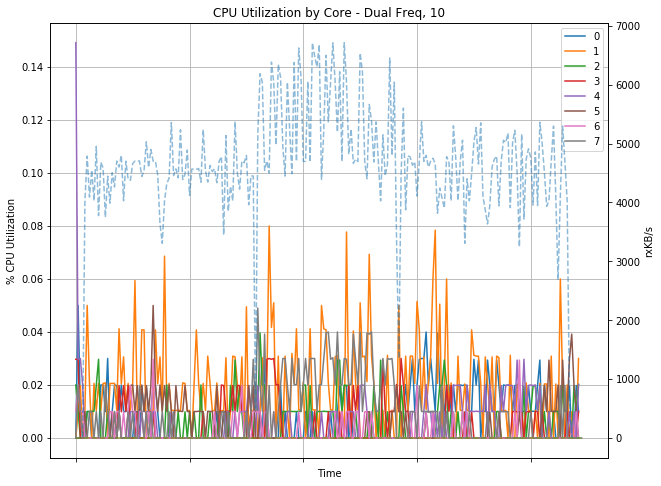

In [2]:
cpu_10_dual_df = plot_all('cpu_10_dual.csv', 'net_10_dual.csv', title='CPU Utilization by Core - Dual Freq, 10')

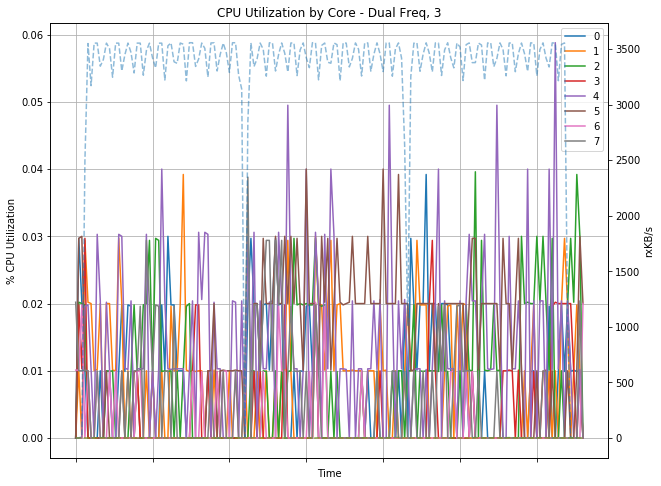

In [3]:
cpu_3_dual_df = plot_all('cpu_3_dual.csv', 'net_3_dual.csv', title='CPU Utilization by Core - Dual Freq, 3')

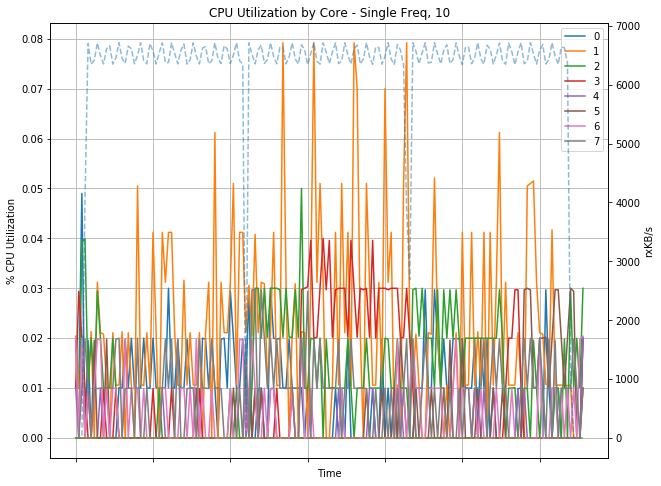

In [4]:
cpu_10_single_df = plot_all('cpu_10_single.csv', 'net_10_single.csv', title='CPU Utilization by Core - Single Freq, 10')

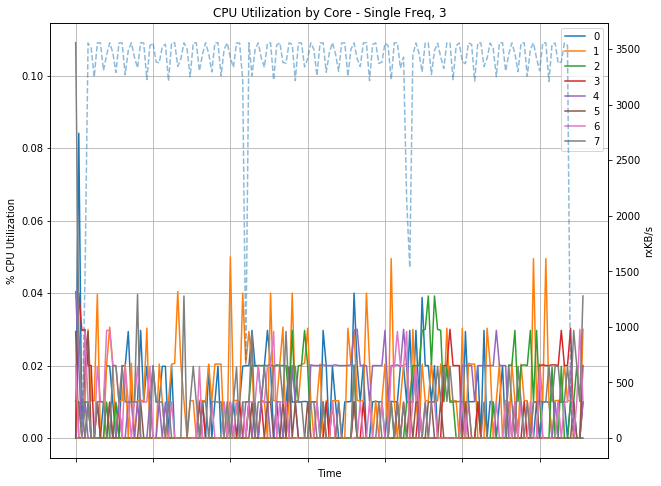

In [5]:
cpu_3_single_df = plot_all('cpu_3_single.csv', 'net_3_single.csv', title='CPU Utilization by Core - Single Freq, 3')

As we can see, the CPU utilization of any single core across all four runs never exceeds ~8% utilization. Another thing we want to point out here is that recalling from our [jitter analysis](../jitter/jitter.ipynb) among these four plots that we are showing in this document, the first one plotted on this sheet (dual freq, dual exposure, `10` schema) was what we referred to as an *unstable* imager configuration. Indeed, if we look at that first plot here vs. the bottom three (which were considered *stable* in the jitter analysis) we can see that the delivery of bytes from the camera to the PC running `ifm3d` (blue dashed trace in the plots) in the *unstable* configuration is quite erratic whereas in the *stable* configurations the byte delivery from the camera is steady and consistent. This is another clear signal showing that the O3X running with the first configuration is *unstable* and should be avoided. 